In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='250'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/profiles-v2-pca'

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2, 
    PlotHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v2', f'profile_list_v2.json')
INPUT_PT_PATH = f"/workspace/profiles-v2-pca-5-sample-{EXPERIMENT_NUM}.pt"
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/profiles-v2-pca/profiles_v2_experiment_250_20250720_2123


In [3]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = torch.load(INPUT_PT_PATH)

Saved figure to /workspace/profiles-v2-pca/profiles_v2_experiment_250_20250720_2123/density_plot.png


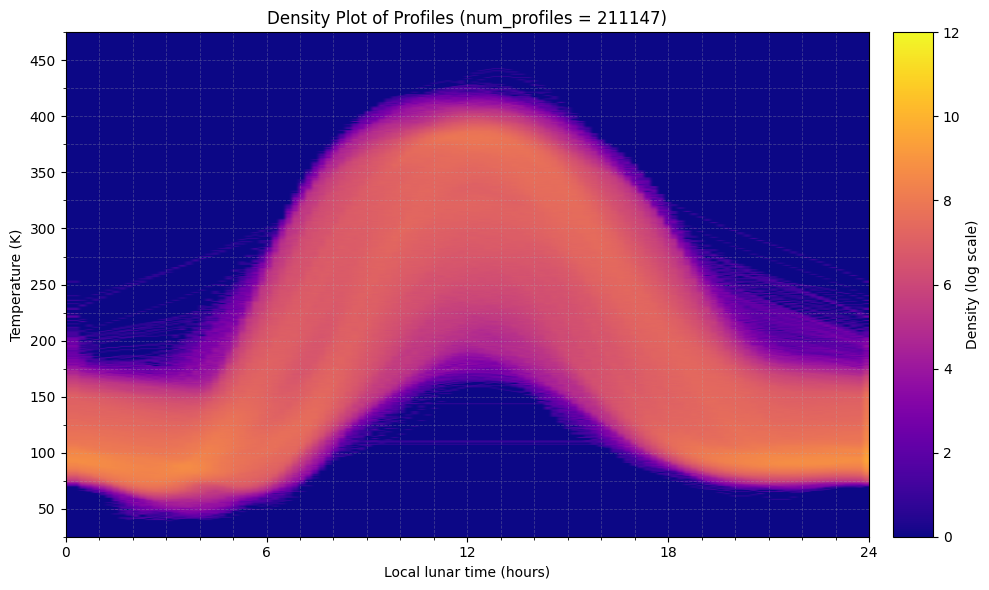

In [4]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [5]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 191.1250
STD: 95.9664
Min Temp: 40.0240
Max Temp: 442.1840
Datasets:
Training Data: 147802
Validation Data: 42229
Test Data: 21116


In [6]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

[Training] Epoch 1/100: 100%|██████████| 740/740 [00:25<00:00, 28.60it/s, best_loss=0.4116]


[Training] Epoch 1/100, L1 Loss: 0.6039, L2 Loss: 0.5962, KL Loss: 0.5678, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 212/212 [00:02<00:00, 103.43it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5617, Val L2 Loss: 0.5394, Val KL Loss: 0.6077
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_250_20250720_2123'


[Training] Epoch 2/100: 100%|██████████| 740/740 [00:24<00:00, 29.76it/s, best_loss=0.5833]


[Training] Epoch 2/100, L1 Loss: 0.5792, L2 Loss: 0.5615, KL Loss: 0.6053, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 212/212 [00:02<00:00, 98.57it/s] 


[Validation] Epoch 2/100, Val L1 Loss: 0.5338, Val L2 Loss: 0.5175, Val KL Loss: 0.5893
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_250_20250720_2123'


[Training] Epoch 3/100: 100%|██████████| 740/740 [00:25<00:00, 29.24it/s, best_loss=0.5707]


[Training] Epoch 3/100, L1 Loss: 0.5781, L2 Loss: 0.5606, KL Loss: 0.6083, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 212/212 [00:02<00:00, 104.90it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5351, Val L2 Loss: 0.5185, Val KL Loss: 0.5901


[Training] Epoch 4/100: 100%|██████████| 740/740 [00:25<00:00, 28.86it/s, best_loss=0.5017]


[Training] Epoch 4/100, L1 Loss: 0.5771, L2 Loss: 0.5586, KL Loss: 0.6075, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 212/212 [00:02<00:00, 100.38it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5430, Val L2 Loss: 0.5256, Val KL Loss: 0.5677


[Training] Epoch 5/100: 100%|██████████| 740/740 [00:25<00:00, 29.14it/s, best_loss=0.5020]


[Training] Epoch 5/100, L1 Loss: 0.5772, L2 Loss: 0.5587, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 212/212 [00:02<00:00, 96.47it/s] 


[Validation] Epoch 5/100, Val L1 Loss: 0.5366, Val L2 Loss: 0.5200, Val KL Loss: 0.6346


[Training] Epoch 6/100: 100%|██████████| 740/740 [00:25<00:00, 28.93it/s, best_loss=0.5824]


[Training] Epoch 6/100, L1 Loss: 0.5773, L2 Loss: 0.5589, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 212/212 [00:02<00:00, 100.71it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5417, Val L2 Loss: 0.5234, Val KL Loss: 0.5821


[Training] Epoch 7/100: 100%|██████████| 740/740 [00:25<00:00, 28.88it/s, best_loss=0.5835]


[Training] Epoch 7/100, L1 Loss: 0.5774, L2 Loss: 0.5591, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 212/212 [00:02<00:00, 105.09it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5342, Val L2 Loss: 0.5181, Val KL Loss: 0.5962


[Training] Epoch 8/100: 100%|██████████| 740/740 [00:25<00:00, 29.19it/s, best_loss=0.3085]


[Training] Epoch 8/100, L1 Loss: 0.5769, L2 Loss: 0.5584, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 212/212 [00:02<00:00, 101.81it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5357, Val L2 Loss: 0.5199, Val KL Loss: 0.5847


[Training] Epoch 9/100: 100%|██████████| 740/740 [00:25<00:00, 29.12it/s, best_loss=0.5849]


[Training] Epoch 9/100, L1 Loss: 0.5772, L2 Loss: 0.5588, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 212/212 [00:02<00:00, 98.34it/s] 


[Validation] Epoch 9/100, Val L1 Loss: 0.5382, Val L2 Loss: 0.5212, Val KL Loss: 0.5733


[Training] Epoch 10/100: 100%|██████████| 740/740 [00:25<00:00, 28.89it/s, best_loss=0.5902]


[Training] Epoch 10/100, L1 Loss: 0.5777, L2 Loss: 0.5600, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 212/212 [00:02<00:00, 101.01it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5430, Val L2 Loss: 0.5251, Val KL Loss: 0.5731


[Training] Epoch 11/100: 100%|██████████| 740/740 [00:25<00:00, 28.83it/s, best_loss=0.5807]


[Training] Epoch 11/100, L1 Loss: 0.5771, L2 Loss: 0.5587, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 212/212 [00:02<00:00, 100.87it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5366, Val L2 Loss: 0.5196, Val KL Loss: 0.6405


[Training] Epoch 12/100: 100%|██████████| 740/740 [00:25<00:00, 29.23it/s, best_loss=0.5800]


[Training] Epoch 12/100, L1 Loss: 0.5776, L2 Loss: 0.5594, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 212/212 [00:02<00:00, 104.87it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5292, Val L2 Loss: 0.5148, Val KL Loss: 0.6511
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_250_20250720_2123'


[Training] Epoch 13/100: 100%|██████████| 740/740 [00:25<00:00, 28.95it/s, best_loss=0.5881]


[Training] Epoch 13/100, L1 Loss: 0.5779, L2 Loss: 0.5598, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 212/212 [00:02<00:00, 103.27it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5167, Val KL Loss: 0.5891


[Training] Epoch 14/100: 100%|██████████| 740/740 [00:25<00:00, 28.99it/s, best_loss=0.5646]


[Training] Epoch 14/100, L1 Loss: 0.5772, L2 Loss: 0.5588, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 212/212 [00:02<00:00, 100.10it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5459, Val L2 Loss: 0.5268, Val KL Loss: 0.5748


[Training] Epoch 15/100: 100%|██████████| 740/740 [00:25<00:00, 28.59it/s, best_loss=0.5802]


[Training] Epoch 15/100, L1 Loss: 0.5786, L2 Loss: 0.5622, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 212/212 [00:02<00:00, 104.60it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5293, Val L2 Loss: 0.5147, Val KL Loss: 0.6088


[Training] Epoch 16/100: 100%|██████████| 740/740 [00:25<00:00, 29.11it/s, best_loss=0.5782]


[Training] Epoch 16/100, L1 Loss: 0.5772, L2 Loss: 0.5589, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 212/212 [00:02<00:00, 98.26it/s] 


[Validation] Epoch 16/100, Val L1 Loss: 0.5496, Val L2 Loss: 0.5299, Val KL Loss: 0.5757


[Training] Epoch 17/100: 100%|██████████| 740/740 [00:25<00:00, 29.11it/s, best_loss=0.5855]


[Training] Epoch 17/100, L1 Loss: 0.5777, L2 Loss: 0.5597, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 212/212 [00:02<00:00, 101.08it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5471, Val L2 Loss: 0.5284, Val KL Loss: 0.5843


[Training] Epoch 18/100: 100%|██████████| 740/740 [00:25<00:00, 28.78it/s, best_loss=0.5995]


[Training] Epoch 18/100, L1 Loss: 0.5780, L2 Loss: 0.5602, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 212/212 [00:02<00:00, 103.45it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5300, Val L2 Loss: 0.5146, Val KL Loss: 0.6237


[Training] Epoch 19/100: 100%|██████████| 740/740 [00:25<00:00, 28.99it/s, best_loss=0.5818]


[Training] Epoch 19/100, L1 Loss: 0.5773, L2 Loss: 0.5590, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 212/212 [00:02<00:00, 100.22it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5540, Val L2 Loss: 0.5335, Val KL Loss: 0.5594


[Training] Epoch 20/100: 100%|██████████| 740/740 [00:25<00:00, 28.60it/s, best_loss=0.5734]


[Training] Epoch 20/100, L1 Loss: 0.5773, L2 Loss: 0.5590, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 212/212 [00:02<00:00, 96.93it/s] 


[Validation] Epoch 20/100, Val L1 Loss: 0.5498, Val L2 Loss: 0.5296, Val KL Loss: 0.5557


[Training] Epoch 21/100: 100%|██████████| 740/740 [00:25<00:00, 29.38it/s, best_loss=0.5793]


[Training] Epoch 21/100, L1 Loss: 0.5776, L2 Loss: 0.5595, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 212/212 [00:02<00:00, 102.87it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5450, Val L2 Loss: 0.5256, Val KL Loss: 0.5617


[Training] Epoch 22/100: 100%|██████████| 740/740 [00:25<00:00, 28.87it/s, best_loss=0.5820]


[Training] Epoch 22/100, L1 Loss: 0.5772, L2 Loss: 0.5590, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 212/212 [00:02<00:00, 100.26it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5369, Val L2 Loss: 0.5200, Val KL Loss: 0.6494


[Training] Epoch 23/100: 100%|██████████| 740/740 [00:25<00:00, 28.88it/s, best_loss=0.5777]


[Training] Epoch 23/100, L1 Loss: 0.5779, L2 Loss: 0.5600, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 212/212 [00:02<00:00, 102.59it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5315, Val L2 Loss: 0.5162, Val KL Loss: 0.6193


[Training] Epoch 24/100: 100%|██████████| 740/740 [00:25<00:00, 28.77it/s, best_loss=0.5897]


[Training] Epoch 24/100, L1 Loss: 0.5779, L2 Loss: 0.5599, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 212/212 [00:02<00:00, 101.66it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5430, Val L2 Loss: 0.5249, Val KL Loss: 0.5654


[Training] Epoch 25/100: 100%|██████████| 740/740 [00:25<00:00, 28.84it/s, best_loss=0.5679]


[Training] Epoch 25/100, L1 Loss: 0.5773, L2 Loss: 0.5590, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 212/212 [00:02<00:00, 103.90it/s]


[Validation] Epoch 25/100, Val L1 Loss: 0.5358, Val L2 Loss: 0.5191, Val KL Loss: 0.5685


[Training] Epoch 26/100: 100%|██████████| 740/740 [00:25<00:00, 28.86it/s, best_loss=0.5879]


[Training] Epoch 26/100, L1 Loss: 0.5785, L2 Loss: 0.5615, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 212/212 [00:02<00:00, 98.45it/s] 


[Validation] Epoch 26/100, Val L1 Loss: 0.5284, Val L2 Loss: 0.5137, Val KL Loss: 0.6291
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_250_20250720_2123'


[Training] Epoch 27/100: 100%|██████████| 740/740 [00:25<00:00, 28.98it/s, best_loss=0.5852]


[Training] Epoch 27/100, L1 Loss: 0.5777, L2 Loss: 0.5591, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 212/212 [00:02<00:00, 100.31it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5389, Val L2 Loss: 0.5216, Val KL Loss: 0.5788


[Training] Epoch 28/100: 100%|██████████| 740/740 [00:25<00:00, 28.86it/s, best_loss=0.5829]


[Training] Epoch 28/100, L1 Loss: 0.5773, L2 Loss: 0.5590, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 212/212 [00:02<00:00, 99.33it/s] 


[Validation] Epoch 28/100, Val L1 Loss: 0.5455, Val L2 Loss: 0.5271, Val KL Loss: 0.5544


[Training] Epoch 29/100: 100%|██████████| 740/740 [00:25<00:00, 28.72it/s, best_loss=0.5723]


[Training] Epoch 29/100, L1 Loss: 0.5775, L2 Loss: 0.5596, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 212/212 [00:02<00:00, 99.83it/s] 


[Validation] Epoch 29/100, Val L1 Loss: 0.5316, Val L2 Loss: 0.5161, Val KL Loss: 0.5981


[Training] Epoch 30/100: 100%|██████████| 740/740 [00:25<00:00, 28.91it/s, best_loss=0.5740]


[Training] Epoch 30/100, L1 Loss: 0.5776, L2 Loss: 0.5594, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 212/212 [00:02<00:00, 98.91it/s] 


[Validation] Epoch 30/100, Val L1 Loss: 0.5329, Val L2 Loss: 0.5170, Val KL Loss: 0.5884


[Training] Epoch 31/100: 100%|██████████| 740/740 [00:25<00:00, 28.68it/s, best_loss=0.5663]


[Training] Epoch 31/100, L1 Loss: 0.5773, L2 Loss: 0.5591, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 212/212 [00:02<00:00, 97.22it/s] 


[Validation] Epoch 31/100, Val L1 Loss: 0.5566, Val L2 Loss: 0.5359, Val KL Loss: 0.5739


[Training] Epoch 32/100: 100%|██████████| 740/740 [00:25<00:00, 29.29it/s, best_loss=0.3415]


[Training] Epoch 32/100, L1 Loss: 0.5770, L2 Loss: 0.5586, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 212/212 [00:02<00:00, 99.17it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5394, Val L2 Loss: 0.5220, Val KL Loss: 0.5920


[Training] Epoch 33/100: 100%|██████████| 740/740 [00:25<00:00, 28.57it/s, best_loss=0.5716]


[Training] Epoch 33/100, L1 Loss: 0.5778, L2 Loss: 0.5602, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 212/212 [00:02<00:00, 98.91it/s] 


[Validation] Epoch 33/100, Val L1 Loss: 0.5384, Val L2 Loss: 0.5210, Val KL Loss: 0.5663


[Training] Epoch 34/100: 100%|██████████| 740/740 [00:25<00:00, 28.90it/s, best_loss=0.5877]


[Training] Epoch 34/100, L1 Loss: 0.5778, L2 Loss: 0.5601, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 212/212 [00:02<00:00, 100.80it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5369, Val L2 Loss: 0.5198, Val KL Loss: 0.5854


[Training] Epoch 35/100: 100%|██████████| 740/740 [00:25<00:00, 29.27it/s, best_loss=0.5983]


[Training] Epoch 35/100, L1 Loss: 0.5770, L2 Loss: 0.5585, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 212/212 [00:02<00:00, 98.92it/s] 


[Validation] Epoch 35/100, Val L1 Loss: 0.5436, Val L2 Loss: 0.5253, Val KL Loss: 0.5519


[Training] Epoch 36/100: 100%|██████████| 740/740 [00:25<00:00, 28.72it/s, best_loss=0.5758]


[Training] Epoch 36/100, L1 Loss: 0.5774, L2 Loss: 0.5589, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 212/212 [00:02<00:00, 103.27it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5498, Val L2 Loss: 0.5303, Val KL Loss: 0.5625


[Training] Epoch 37/100: 100%|██████████| 740/740 [00:25<00:00, 29.03it/s, best_loss=0.5839]


[Training] Epoch 37/100, L1 Loss: 0.5777, L2 Loss: 0.5594, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 212/212 [00:02<00:00, 103.20it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5499, Val L2 Loss: 0.5299, Val KL Loss: 0.5553


[Training] Epoch 38/100: 100%|██████████| 740/740 [00:25<00:00, 28.72it/s, best_loss=0.5814]


[Training] Epoch 38/100, L1 Loss: 0.5777, L2 Loss: 0.5594, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 212/212 [00:02<00:00, 96.93it/s] 


[Validation] Epoch 38/100, Val L1 Loss: 0.5394, Val L2 Loss: 0.5220, Val KL Loss: 0.5829


[Training] Epoch 39/100: 100%|██████████| 740/740 [00:25<00:00, 29.21it/s, best_loss=0.5682]


[Training] Epoch 39/100, L1 Loss: 0.5781, L2 Loss: 0.5599, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 212/212 [00:02<00:00, 102.13it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5465, Val L2 Loss: 0.5273, Val KL Loss: 0.5973


[Training] Epoch 40/100: 100%|██████████| 740/740 [00:25<00:00, 28.91it/s, best_loss=0.5889]


[Training] Epoch 40/100, L1 Loss: 0.5772, L2 Loss: 0.5590, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 212/212 [00:02<00:00, 100.36it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5397, Val L2 Loss: 0.5220, Val KL Loss: 0.5795


[Training] Epoch 41/100: 100%|██████████| 740/740 [00:25<00:00, 28.82it/s, best_loss=0.5743]


[Training] Epoch 41/100, L1 Loss: 0.5774, L2 Loss: 0.5590, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 212/212 [00:02<00:00, 99.61it/s] 


[Validation] Epoch 41/100, Val L1 Loss: 0.5396, Val L2 Loss: 0.5227, Val KL Loss: 0.5727


[Training] Epoch 42/100: 100%|██████████| 740/740 [00:25<00:00, 28.69it/s, best_loss=0.5785]


[Training] Epoch 42/100, L1 Loss: 0.5778, L2 Loss: 0.5600, KL Loss: 0.6077, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 212/212 [00:02<00:00, 97.58it/s] 


[Validation] Epoch 42/100, Val L1 Loss: 0.5384, Val L2 Loss: 0.5211, Val KL Loss: 0.5839


[Training] Epoch 43/100: 100%|██████████| 740/740 [00:25<00:00, 28.94it/s, best_loss=0.5709]


[Training] Epoch 43/100, L1 Loss: 0.5773, L2 Loss: 0.5590, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 212/212 [00:02<00:00, 98.28it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5558, Val L2 Loss: 0.5348, Val KL Loss: 0.5940


[Training] Epoch 44/100: 100%|██████████| 740/740 [00:25<00:00, 28.79it/s, best_loss=0.5632]


[Training] Epoch 44/100, L1 Loss: 0.5776, L2 Loss: 0.5597, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 212/212 [00:02<00:00, 99.37it/s] 


[Validation] Epoch 44/100, Val L1 Loss: 0.5307, Val L2 Loss: 0.5153, Val KL Loss: 0.5928


[Training] Epoch 45/100: 100%|██████████| 740/740 [00:25<00:00, 28.58it/s, best_loss=0.5851]


[Training] Epoch 45/100, L1 Loss: 0.5776, L2 Loss: 0.5595, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 212/212 [00:02<00:00, 99.22it/s] 


[Validation] Epoch 45/100, Val L1 Loss: 0.5371, Val L2 Loss: 0.5202, Val KL Loss: 0.5741


[Training] Epoch 46/100: 100%|██████████| 740/740 [00:25<00:00, 28.96it/s, best_loss=0.4911]


[Training] Epoch 46/100, L1 Loss: 0.5771, L2 Loss: 0.5586, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 212/212 [00:02<00:00, 102.68it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5498, Val L2 Loss: 0.5302, Val KL Loss: 0.5739


[Training] Epoch 47/100: 100%|██████████| 740/740 [00:25<00:00, 28.66it/s, best_loss=0.5860]


[Training] Epoch 47/100, L1 Loss: 0.5776, L2 Loss: 0.5593, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 212/212 [00:02<00:00, 99.51it/s] 


[Validation] Epoch 47/100, Val L1 Loss: 0.5372, Val L2 Loss: 0.5201, Val KL Loss: 0.5841


[Training] Epoch 48/100: 100%|██████████| 740/740 [00:25<00:00, 28.55it/s, best_loss=0.5714]


[Training] Epoch 48/100, L1 Loss: 0.5776, L2 Loss: 0.5594, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 212/212 [00:02<00:00, 103.68it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5348, Val L2 Loss: 0.5189, Val KL Loss: 0.6364


[Training] Epoch 49/100: 100%|██████████| 740/740 [00:25<00:00, 28.72it/s, best_loss=0.5649]


[Training] Epoch 49/100, L1 Loss: 0.5779, L2 Loss: 0.5599, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 212/212 [00:02<00:00, 94.89it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5309, Val L2 Loss: 0.5156, Val KL Loss: 0.5895


[Training] Epoch 50/100: 100%|██████████| 740/740 [00:25<00:00, 28.72it/s, best_loss=0.5776]


[Training] Epoch 50/100, L1 Loss: 0.5775, L2 Loss: 0.5593, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 212/212 [00:02<00:00, 102.72it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5407, Val L2 Loss: 0.5233, Val KL Loss: 0.5878


[Training] Epoch 51/100: 100%|██████████| 740/740 [00:25<00:00, 28.59it/s, best_loss=0.5889]


[Training] Epoch 51/100, L1 Loss: 0.5782, L2 Loss: 0.5603, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 212/212 [00:02<00:00, 101.18it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5259, Val L2 Loss: 0.5120, Val KL Loss: 0.6237
[Validation] Saved checkpoint in '/workspace/profiles-v2-pca/profiles_v2_experiment_250_20250720_2123'


[Training] Epoch 52/100: 100%|██████████| 740/740 [00:25<00:00, 28.97it/s, best_loss=0.5804]


[Training] Epoch 52/100, L1 Loss: 0.5773, L2 Loss: 0.5593, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 212/212 [00:02<00:00, 103.40it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5424, Val L2 Loss: 0.5242, Val KL Loss: 0.5761


[Training] Epoch 53/100: 100%|██████████| 740/740 [00:25<00:00, 29.06it/s, best_loss=0.5827]


[Training] Epoch 53/100, L1 Loss: 0.5773, L2 Loss: 0.5588, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 212/212 [00:02<00:00, 99.53it/s] 


[Validation] Epoch 53/100, Val L1 Loss: 0.5464, Val L2 Loss: 0.5270, Val KL Loss: 0.5531


[Training] Epoch 54/100: 100%|██████████| 740/740 [00:25<00:00, 29.05it/s, best_loss=0.5893]


[Training] Epoch 54/100, L1 Loss: 0.5774, L2 Loss: 0.5592, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 212/212 [00:02<00:00, 102.22it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5311, Val L2 Loss: 0.5158, Val KL Loss: 0.6183


[Training] Epoch 55/100: 100%|██████████| 740/740 [00:26<00:00, 28.42it/s, best_loss=0.5793]


[Training] Epoch 55/100, L1 Loss: 0.5776, L2 Loss: 0.5595, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 212/212 [00:02<00:00, 86.44it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5637, Val L2 Loss: 0.5418, Val KL Loss: 0.5520


[Training] Epoch 56/100: 100%|██████████| 740/740 [00:26<00:00, 28.22it/s, best_loss=0.5877]


[Training] Epoch 56/100, L1 Loss: 0.5774, L2 Loss: 0.5591, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 212/212 [00:02<00:00, 100.99it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5344, Val L2 Loss: 0.5184, Val KL Loss: 0.6455


[Training] Epoch 57/100: 100%|██████████| 740/740 [00:25<00:00, 28.71it/s, best_loss=0.5853]


[Training] Epoch 57/100, L1 Loss: 0.5779, L2 Loss: 0.5598, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 212/212 [00:02<00:00, 99.39it/s] 


[Validation] Epoch 57/100, Val L1 Loss: 0.5486, Val L2 Loss: 0.5288, Val KL Loss: 0.5762


[Training] Epoch 58/100: 100%|██████████| 740/740 [00:26<00:00, 28.40it/s, best_loss=0.5032]


[Training] Epoch 58/100, L1 Loss: 0.5771, L2 Loss: 0.5586, KL Loss: 0.6077, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 212/212 [00:02<00:00, 102.96it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5410, Val L2 Loss: 0.5233, Val KL Loss: 0.5987


[Training] Epoch 59/100: 100%|██████████| 740/740 [00:25<00:00, 28.92it/s, best_loss=0.5932]


[Training] Epoch 59/100, L1 Loss: 0.5786, L2 Loss: 0.5620, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 212/212 [00:02<00:00, 104.09it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5273, Val L2 Loss: 0.5132, Val KL Loss: 0.6871


[Training] Epoch 60/100: 100%|██████████| 740/740 [00:25<00:00, 29.06it/s, best_loss=0.5951]


[Training] Epoch 60/100, L1 Loss: 0.5779, L2 Loss: 0.5601, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 212/212 [00:02<00:00, 96.56it/s] 


[Validation] Epoch 60/100, Val L1 Loss: 0.5537, Val L2 Loss: 0.5340, Val KL Loss: 0.6038


[Training] Epoch 61/100: 100%|██████████| 740/740 [00:25<00:00, 28.94it/s, best_loss=0.5745]


[Training] Epoch 61/100, L1 Loss: 0.5776, L2 Loss: 0.5593, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 212/212 [00:02<00:00, 100.44it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5399, Val L2 Loss: 0.5220, Val KL Loss: 0.5885


[Training] Epoch 62/100: 100%|██████████| 740/740 [00:25<00:00, 29.06it/s, best_loss=0.5667]


[Training] Epoch 62/100, L1 Loss: 0.5776, L2 Loss: 0.5595, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 212/212 [00:02<00:00, 90.15it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5548, Val L2 Loss: 0.5344, Val KL Loss: 0.5484


[Training] Epoch 63/100: 100%|██████████| 740/740 [00:26<00:00, 28.35it/s, best_loss=0.5699]


[Training] Epoch 63/100, L1 Loss: 0.5775, L2 Loss: 0.5590, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 212/212 [00:02<00:00, 105.16it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5561, Val L2 Loss: 0.5354, Val KL Loss: 0.5568


[Training] Epoch 64/100: 100%|██████████| 740/740 [00:25<00:00, 28.94it/s, best_loss=0.5728]


[Training] Epoch 64/100, L1 Loss: 0.5777, L2 Loss: 0.5595, KL Loss: 0.6077, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 212/212 [00:02<00:00, 100.93it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5412, Val L2 Loss: 0.5232, Val KL Loss: 0.5774


[Training] Epoch 65/100: 100%|██████████| 740/740 [00:25<00:00, 28.62it/s, best_loss=0.4339]


[Training] Epoch 65/100, L1 Loss: 0.5774, L2 Loss: 0.5589, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 212/212 [00:02<00:00, 99.51it/s] 


[Validation] Epoch 65/100, Val L1 Loss: 0.5419, Val L2 Loss: 0.5241, Val KL Loss: 0.5985


[Training] Epoch 66/100: 100%|██████████| 740/740 [00:25<00:00, 29.01it/s, best_loss=0.5759]


[Training] Epoch 66/100, L1 Loss: 0.5777, L2 Loss: 0.5596, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 212/212 [00:02<00:00, 101.09it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5364, Val L2 Loss: 0.5200, Val KL Loss: 0.5915


[Training] Epoch 67/100: 100%|██████████| 740/740 [00:25<00:00, 28.47it/s, best_loss=0.5832]


[Training] Epoch 67/100, L1 Loss: 0.5781, L2 Loss: 0.5604, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 212/212 [00:02<00:00, 100.37it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5345, Val L2 Loss: 0.5180, Val KL Loss: 0.6041


[Training] Epoch 68/100: 100%|██████████| 740/740 [00:25<00:00, 28.52it/s, best_loss=0.5865]


[Training] Epoch 68/100, L1 Loss: 0.5777, L2 Loss: 0.5596, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 212/212 [00:02<00:00, 99.48it/s] 


[Validation] Epoch 68/100, Val L1 Loss: 0.5499, Val L2 Loss: 0.5300, Val KL Loss: 0.5642


[Training] Epoch 69/100: 100%|██████████| 740/740 [00:26<00:00, 27.88it/s, best_loss=0.5728]


[Training] Epoch 69/100, L1 Loss: 0.5773, L2 Loss: 0.5589, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 212/212 [00:02<00:00, 93.83it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5510, Val L2 Loss: 0.5309, Val KL Loss: 0.5492


[Training] Epoch 70/100: 100%|██████████| 740/740 [00:25<00:00, 28.53it/s, best_loss=0.3994]


[Training] Epoch 70/100, L1 Loss: 0.5770, L2 Loss: 0.5586, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 212/212 [00:02<00:00, 103.25it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5453, Val L2 Loss: 0.5261, Val KL Loss: 0.5742


[Training] Epoch 71/100: 100%|██████████| 740/740 [00:25<00:00, 29.22it/s, best_loss=0.5779]


[Training] Epoch 71/100, L1 Loss: 0.5784, L2 Loss: 0.5615, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 212/212 [00:02<00:00, 97.88it/s] 


[Validation] Epoch 71/100, Val L1 Loss: 0.5288, Val L2 Loss: 0.5138, Val KL Loss: 0.6223


[Training] Epoch 72/100: 100%|██████████| 740/740 [00:25<00:00, 29.14it/s, best_loss=0.5644]


[Training] Epoch 72/100, L1 Loss: 0.5777, L2 Loss: 0.5594, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 212/212 [00:02<00:00, 102.12it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5305, Val L2 Loss: 0.5156, Val KL Loss: 0.6161


[Training] Epoch 73/100: 100%|██████████| 740/740 [00:25<00:00, 29.18it/s, best_loss=0.5774]


[Training] Epoch 73/100, L1 Loss: 0.5772, L2 Loss: 0.5586, KL Loss: 0.6077, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 212/212 [00:02<00:00, 103.74it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5399, Val L2 Loss: 0.5221, Val KL Loss: 0.5984


[Training] Epoch 74/100: 100%|██████████| 740/740 [00:23<00:00, 31.42it/s, best_loss=0.5851]


[Training] Epoch 74/100, L1 Loss: 0.5774, L2 Loss: 0.5591, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 212/212 [00:01<00:00, 111.05it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5512, Val L2 Loss: 0.5307, Val KL Loss: 0.5670


[Training] Epoch 75/100: 100%|██████████| 740/740 [00:23<00:00, 31.44it/s, best_loss=0.5681]


[Training] Epoch 75/100, L1 Loss: 0.5774, L2 Loss: 0.5588, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 212/212 [00:01<00:00, 107.85it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5496, Val L2 Loss: 0.5302, Val KL Loss: 0.5446


[Training] Epoch 76/100: 100%|██████████| 740/740 [00:23<00:00, 31.18it/s, best_loss=0.4920]


[Training] Epoch 76/100, L1 Loss: 0.5773, L2 Loss: 0.5589, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 212/212 [00:01<00:00, 106.67it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5411, Val L2 Loss: 0.5234, Val KL Loss: 0.5789


[Training] Epoch 77/100: 100%|██████████| 740/740 [00:23<00:00, 31.20it/s, best_loss=0.5638]


[Training] Epoch 77/100, L1 Loss: 0.5774, L2 Loss: 0.5590, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 212/212 [00:01<00:00, 106.53it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5360, Val L2 Loss: 0.5196, Val KL Loss: 0.5885


[Training] Epoch 78/100: 100%|██████████| 740/740 [00:23<00:00, 31.04it/s, best_loss=0.4645]


[Training] Epoch 78/100, L1 Loss: 0.5773, L2 Loss: 0.5589, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 212/212 [00:02<00:00, 102.37it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5557, Val L2 Loss: 0.5341, Val KL Loss: 0.5579


[Training] Epoch 79/100: 100%|██████████| 740/740 [00:23<00:00, 31.59it/s, best_loss=0.5593]


[Training] Epoch 79/100, L1 Loss: 0.5778, L2 Loss: 0.5602, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 212/212 [00:01<00:00, 107.80it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5292, Val L2 Loss: 0.5145, Val KL Loss: 0.6384


[Training] Epoch 80/100: 100%|██████████| 740/740 [00:23<00:00, 31.10it/s, best_loss=0.5759]


[Training] Epoch 80/100, L1 Loss: 0.5772, L2 Loss: 0.5587, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 212/212 [00:01<00:00, 107.78it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5335, Val L2 Loss: 0.5176, Val KL Loss: 0.5981


[Training] Epoch 81/100: 100%|██████████| 740/740 [00:23<00:00, 31.07it/s, best_loss=0.5841]


[Training] Epoch 81/100, L1 Loss: 0.5777, L2 Loss: 0.5598, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 212/212 [00:01<00:00, 108.93it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5358, Val L2 Loss: 0.5189, Val KL Loss: 0.5906


[Training] Epoch 82/100: 100%|██████████| 740/740 [00:23<00:00, 31.23it/s, best_loss=0.5829]


[Training] Epoch 82/100, L1 Loss: 0.5780, L2 Loss: 0.5607, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 212/212 [00:01<00:00, 106.29it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5326, Val L2 Loss: 0.5170, Val KL Loss: 0.6015


[Training] Epoch 83/100: 100%|██████████| 740/740 [00:23<00:00, 31.32it/s, best_loss=0.5862]


[Training] Epoch 83/100, L1 Loss: 0.5773, L2 Loss: 0.5588, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 212/212 [00:01<00:00, 106.68it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5359, Val L2 Loss: 0.5195, Val KL Loss: 0.5829


[Training] Epoch 84/100: 100%|██████████| 740/740 [00:23<00:00, 31.12it/s, best_loss=0.5618]


[Training] Epoch 84/100, L1 Loss: 0.5778, L2 Loss: 0.5598, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 212/212 [00:01<00:00, 111.94it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5470, Val L2 Loss: 0.5275, Val KL Loss: 0.5539


[Training] Epoch 85/100: 100%|██████████| 740/740 [00:23<00:00, 30.89it/s, best_loss=0.4278]


[Training] Epoch 85/100, L1 Loss: 0.5772, L2 Loss: 0.5588, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 212/212 [00:01<00:00, 106.51it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5444, Val L2 Loss: 0.5263, Val KL Loss: 0.5911


[Training] Epoch 86/100: 100%|██████████| 740/740 [00:23<00:00, 31.28it/s, best_loss=0.5597]


[Training] Epoch 86/100, L1 Loss: 0.5773, L2 Loss: 0.5591, KL Loss: 0.6076, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 212/212 [00:01<00:00, 108.68it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5559, Val L2 Loss: 0.5347, Val KL Loss: 0.5740


[Training] Epoch 87/100: 100%|██████████| 740/740 [00:23<00:00, 31.19it/s, best_loss=0.5939]


[Training] Epoch 87/100, L1 Loss: 0.5775, L2 Loss: 0.5592, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 212/212 [00:01<00:00, 111.58it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5382, Val L2 Loss: 0.5210, Val KL Loss: 0.5717


[Training] Epoch 88/100: 100%|██████████| 740/740 [00:24<00:00, 30.63it/s, best_loss=0.5843]


[Training] Epoch 88/100, L1 Loss: 0.5776, L2 Loss: 0.5597, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 212/212 [00:01<00:00, 108.03it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5404, Val L2 Loss: 0.5225, Val KL Loss: 0.5797


[Training] Epoch 89/100: 100%|██████████| 740/740 [00:23<00:00, 31.28it/s, best_loss=0.5775]


[Training] Epoch 89/100, L1 Loss: 0.5773, L2 Loss: 0.5590, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 212/212 [00:01<00:00, 107.33it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5316, Val L2 Loss: 0.5164, Val KL Loss: 0.6199


[Training] Epoch 90/100: 100%|██████████| 740/740 [00:23<00:00, 30.90it/s, best_loss=0.5820]


[Training] Epoch 90/100, L1 Loss: 0.5777, L2 Loss: 0.5595, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 212/212 [00:01<00:00, 108.17it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5442, Val L2 Loss: 0.5256, Val KL Loss: 0.5640


[Training] Epoch 91/100: 100%|██████████| 740/740 [00:23<00:00, 30.99it/s, best_loss=0.5513]


[Training] Epoch 91/100, L1 Loss: 0.5771, L2 Loss: 0.5588, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 212/212 [00:01<00:00, 106.93it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5514, Val L2 Loss: 0.5310, Val KL Loss: 0.5784


[Training] Epoch 92/100: 100%|██████████| 740/740 [00:23<00:00, 30.86it/s, best_loss=0.5049]


[Training] Epoch 92/100, L1 Loss: 0.5773, L2 Loss: 0.5589, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 212/212 [00:01<00:00, 108.96it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5387, Val L2 Loss: 0.5213, Val KL Loss: 0.5875


[Training] Epoch 93/100: 100%|██████████| 740/740 [00:23<00:00, 30.95it/s, best_loss=0.5774]


[Training] Epoch 93/100, L1 Loss: 0.5777, L2 Loss: 0.5595, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 212/212 [00:01<00:00, 106.80it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5310, Val L2 Loss: 0.5156, Val KL Loss: 0.6676


[Training] Epoch 94/100: 100%|██████████| 740/740 [00:23<00:00, 31.29it/s, best_loss=0.5850]


[Training] Epoch 94/100, L1 Loss: 0.5781, L2 Loss: 0.5609, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 212/212 [00:01<00:00, 110.07it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5320, Val L2 Loss: 0.5160, Val KL Loss: 0.6787


[Training] Epoch 95/100: 100%|██████████| 740/740 [00:24<00:00, 30.79it/s, best_loss=0.5644]


[Training] Epoch 95/100, L1 Loss: 0.5773, L2 Loss: 0.5590, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 212/212 [00:01<00:00, 109.25it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5512, Val L2 Loss: 0.5308, Val KL Loss: 0.5505


[Training] Epoch 96/100: 100%|██████████| 740/740 [00:23<00:00, 30.88it/s, best_loss=0.5773]


[Training] Epoch 96/100, L1 Loss: 0.5780, L2 Loss: 0.5604, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 212/212 [00:01<00:00, 108.29it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5592, Val L2 Loss: 0.5379, Val KL Loss: 0.5274


[Training] Epoch 97/100: 100%|██████████| 740/740 [00:23<00:00, 31.23it/s, best_loss=0.5339]


[Training] Epoch 97/100, L1 Loss: 0.5772, L2 Loss: 0.5588, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 212/212 [00:02<00:00, 96.85it/s] 


[Validation] Epoch 97/100, Val L1 Loss: 0.5535, Val L2 Loss: 0.5331, Val KL Loss: 0.5630


[Training] Epoch 98/100: 100%|██████████| 740/740 [00:23<00:00, 31.18it/s, best_loss=0.5824]


[Training] Epoch 98/100, L1 Loss: 0.5774, L2 Loss: 0.5591, KL Loss: 0.6075, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 212/212 [00:01<00:00, 107.16it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5391, Val L2 Loss: 0.5213, Val KL Loss: 0.5860


[Training] Epoch 99/100: 100%|██████████| 740/740 [00:23<00:00, 30.88it/s, best_loss=0.5736]


[Training] Epoch 99/100, L1 Loss: 0.5775, L2 Loss: 0.5591, KL Loss: 0.6078, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 212/212 [00:01<00:00, 107.58it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5332, Val L2 Loss: 0.5171, Val KL Loss: 0.5991


[Training] Epoch 100/100: 100%|██████████| 740/740 [00:23<00:00, 30.84it/s, best_loss=0.5881]


[Training] Epoch 100/100, L1 Loss: 0.5777, L2 Loss: 0.5595, KL Loss: 0.6074, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 212/212 [00:01<00:00, 109.96it/s]


[Validation] Epoch 100/100, Val L1 Loss: 0.5339, Val L2 Loss: 0.5179, Val KL Loss: 0.5961


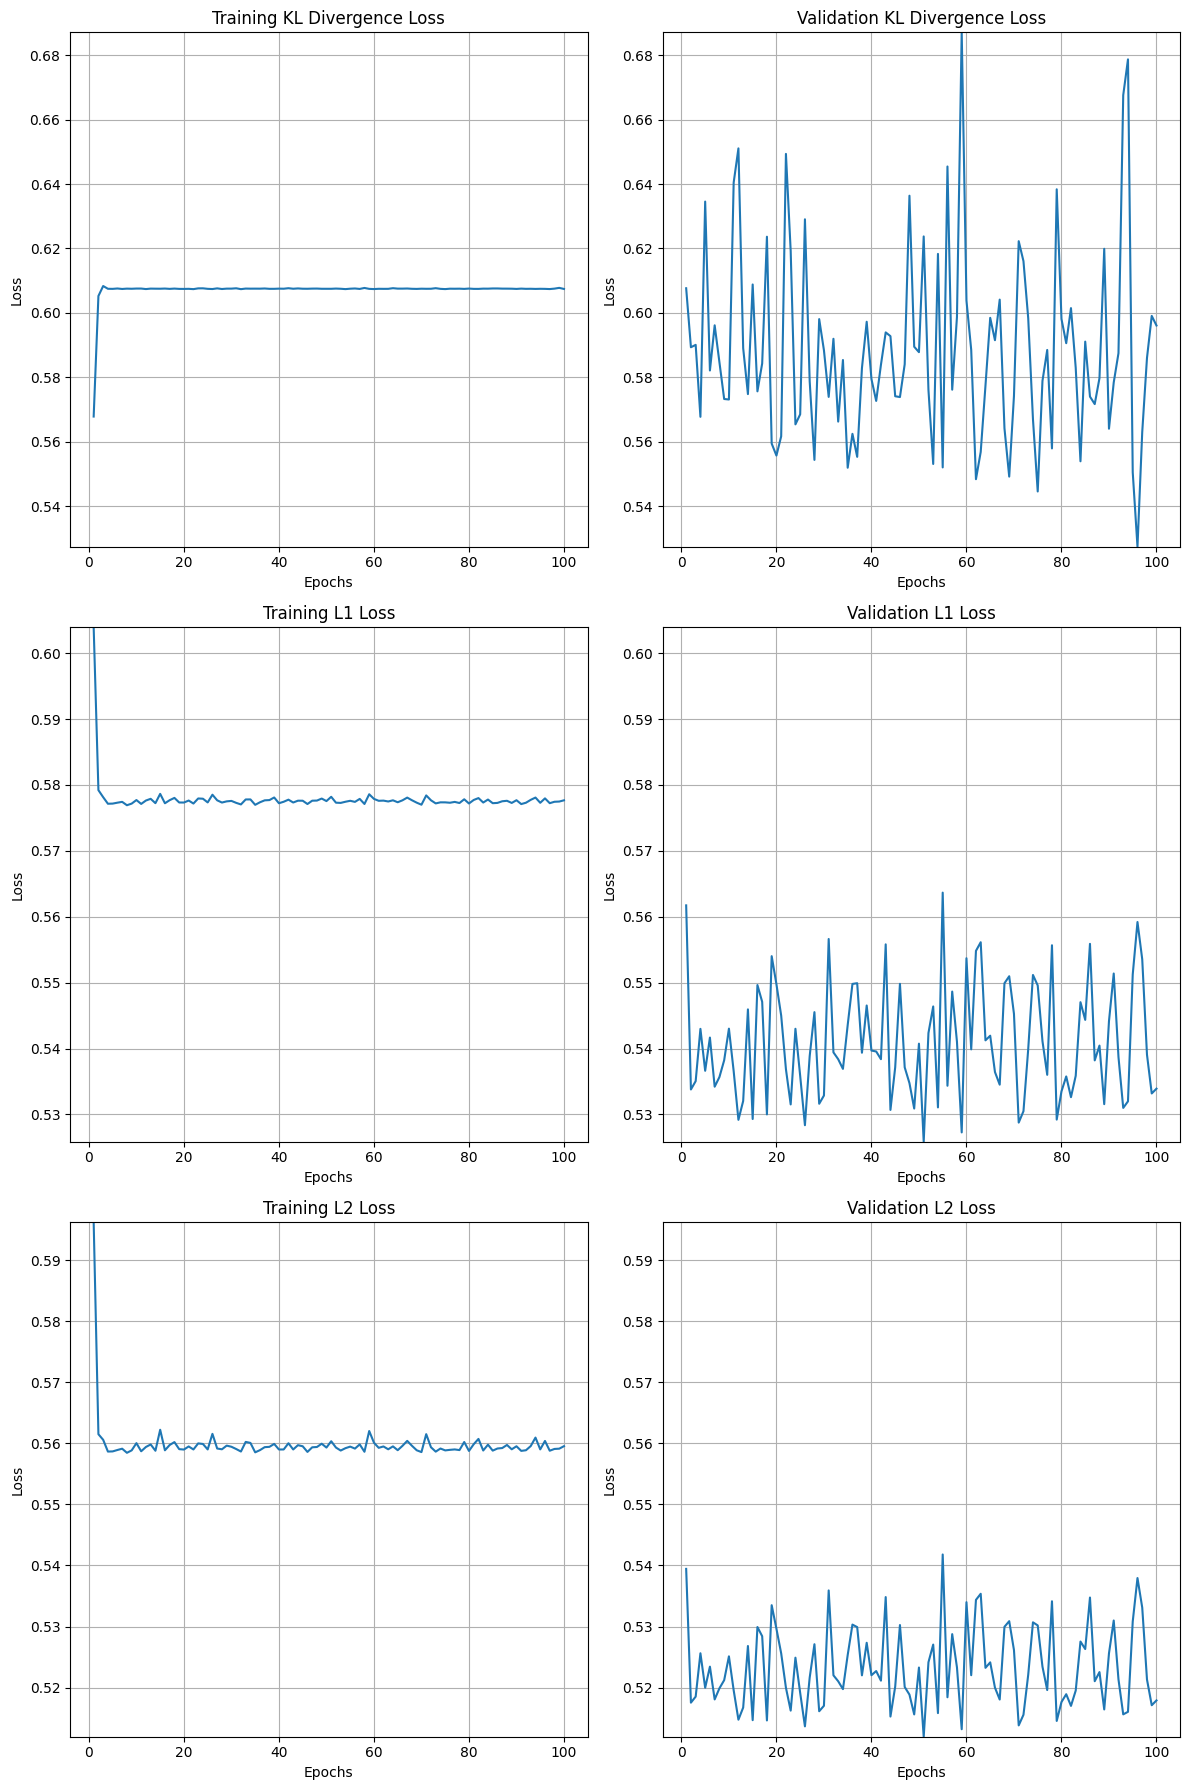

Best Validation Loss in Kelvins:
50.4650 K


In [7]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

# Plot losses
PlotLosses(losses, EPOCHS, model_dir)

# Save losses
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

In [8]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


z0: -0.0075
z1: 0.1204
z2: 0.0130
z3: 0.0454


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 616.29it/s]


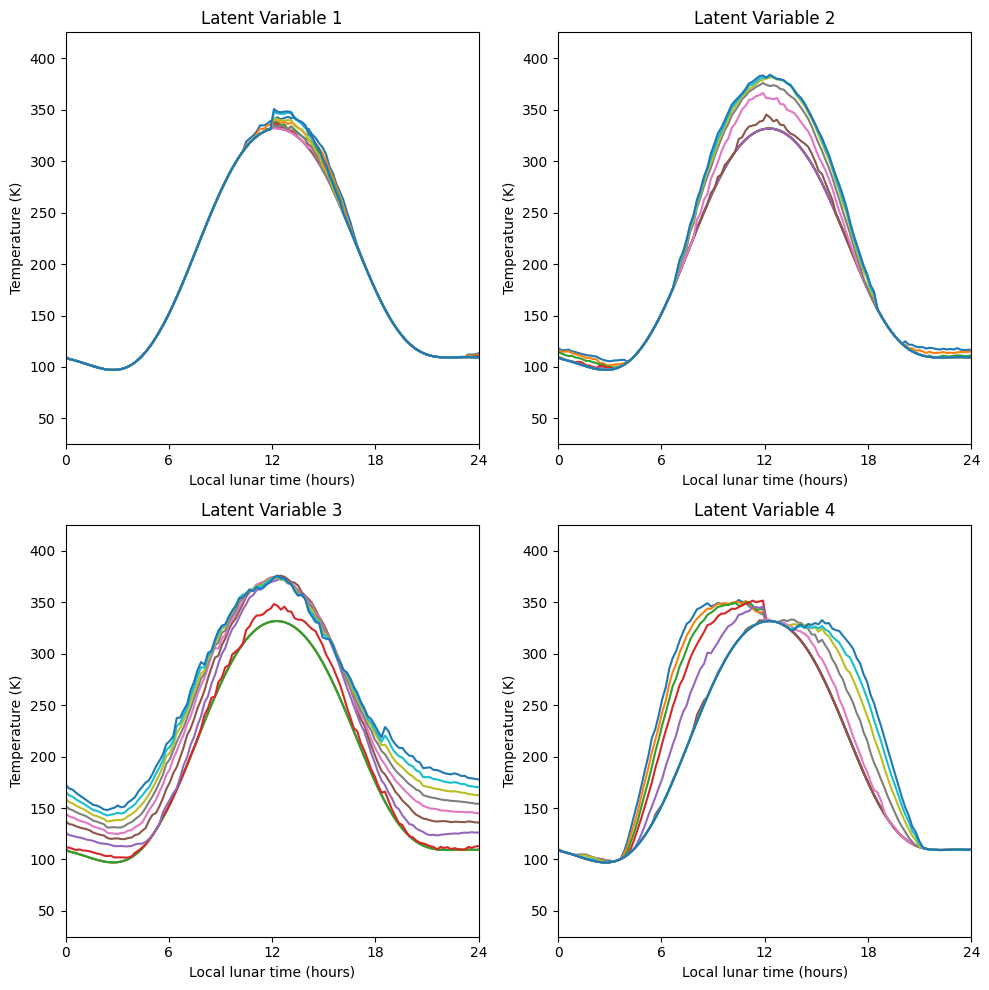

In [9]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)